By now we have discussed process of splitting stocks based off of some characteristic and then creating portfolios to test some hypothesis. We actually found pretty solid evidence that beta is significant predictor of average stock return... or did we?

On average, the portfolios with high betas returned more when the market was doing well. But stocks with high betas may share similar characteristics. i.e., these stocks may be larger on average than small beta stocks. It could be that there are characteristics SHARED amongst the high beta stocks that are the real driving reasons behind return. 

This is the motivation behind the Fama French paper you all read, and now we are going to put some of the methodologies from there to the test!

### PT. 1

Do the following:

1. Select 500 stocks from the index of your choice and get data from 2021-current

2. Create five equally weighted portfolios of 100 stocks each, ranked by beta. To get the beta for each stock, run a linear regression using data from the start of 2021 to the end of 2023.

3. Within each of those portfolios, create five equally weighted portfolios of 20 stocks, ranked by SIZE. To classify size, get the **current** (because histrocial data for this is tough to get) market equity of each stock and use that to rank the stocks.

4. Now that you have your sorted portfolios, track their performances over 2024-current. What patterns do you notice?

Number of tickers in S&P 500 data: 492
Stock returns shape (unfiltered): (753, 492)
Market returns shape: (752,)
Number of tickers processed to calculate beta 492

Beta DataFrame before further filtering:
  Ticker      Beta
0      A  1.055510
1   AAPL  1.273341
2   ABBV  0.366589
3   ABNB  1.627171
4    ABT  0.731691

Beta DataFrame after grouping into 5 Beta Groups:
  Ticker      Beta  Beta_Group
0      A  1.055510           0
1   AAPL  1.273341           0
2   ABBV  0.366589           0
3   ABNB  1.627171           0
4    ABT  0.731691           0
beta_df shape: (492, 3)
Unique Beta Groups: [0 1 2 3 4 5]

beta_df after adding MarketCap:
  Ticker      Beta  Beta_Group     Market_Cap
0      A  1.055510           0    38619705344
1   AAPL  1.273341           0  3688676720640
2   ABBV  0.366589           0   356741939200
3   ABNB  1.627171           0    90759143424
4    ABT  0.731691           0   234013343744

beta_df after dropping rows with missing MarketCap, shape: (492, 4)

Unique 

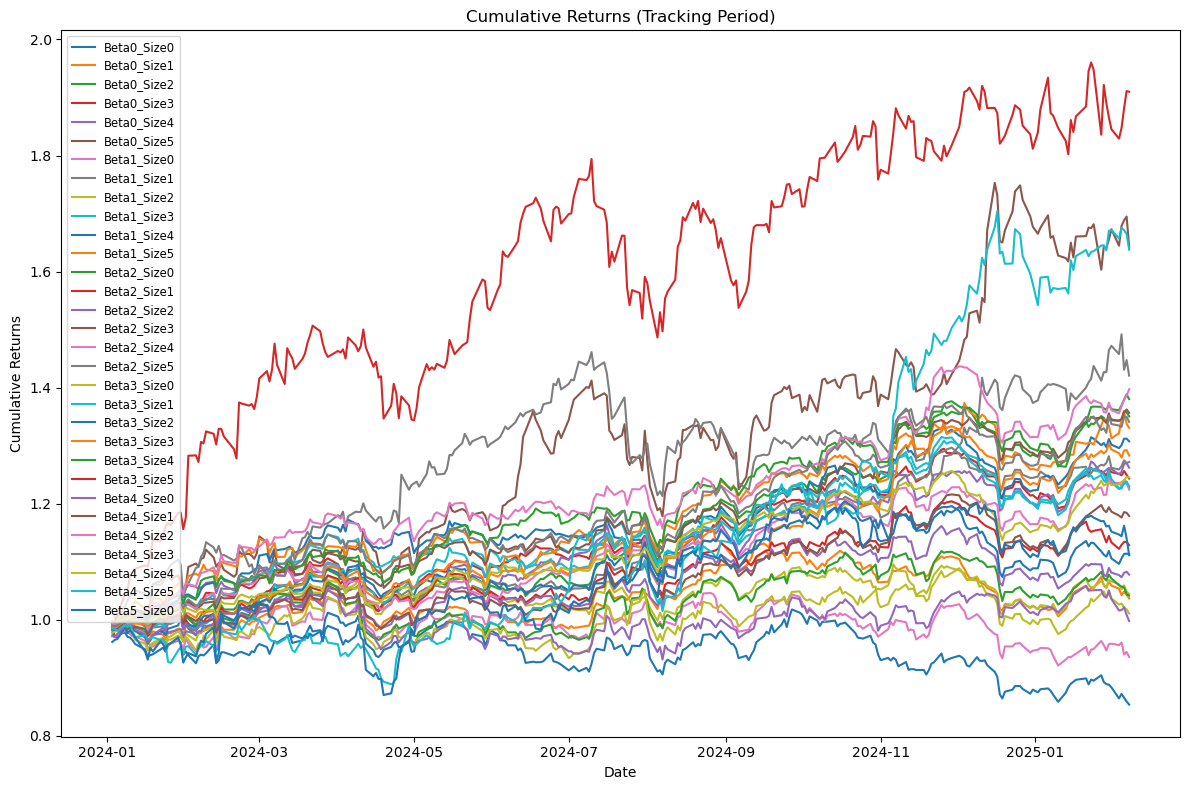

In [14]:
#Hopefully this should be the final one 

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sys

def main():
    #First we gotta load the data from the pkl files

    base_path = "/Users/zakdjahed/Desktop/Pkl Files/"

    try:
        #S&P500 stock price data
        sp_500_data = pd.read_pickle(base_path + "S&P500_Data.pkl")['Close']
        #market data
        market_data = pd.read_pickle(base_path + "Market_Data.pkl")['Close']
        # Load market cap information (assumed to be a dict or DataFrame)
        market_cap = pd.read_pickle(base_path + "Market_Cap.pkl")
        market_cap_series = market_cap.T.iloc[:, 0]

        #print(market_cap.head())

        # Load large and small cap tickers if needed later
        oex = pd.read_pickle(base_path + "OEX.pkl")
        rut = pd.read_pickle(base_path + "RUT.pkl") 
    except Exception as e:
        print("Error, loading pickle files", e)
        sys.exit(1) 


    #define date ranges for beta estimation
    reg_start = "2021-01-01"
    reg_end = "2024-01-01"   # Use data from 2021 to end of 2023 for beta estimation
    track_start = "2024-01-01"
    track_end = datetime.datetime.today().strftime("%Y-%m-%d")

    #Now let's use the pickle files instead of Wikipedia to get S&P data
    tickers =  sp_500_data.columns.tolist()
    print(f"Number of tickers in S&P 500 data: {len(tickers)}")

    #Filter data for regression period in both individual stocks and market
    reg_prices = sp_500_data.loc[reg_start:reg_end]
    if reg_prices.empty:
        print("No regression period data found in S&P_500.pkl")
        sys.exit(1)
    
    market_prices = market_data.loc[reg_start:reg_end]
    if market_prices.empty:
        print("No regression period market data found in Market_Data.pkl")
        sys.exit(1)

    #compute stock returns on a daily basis
    stock_returns = reg_prices.pct_change()
    market_returns = market_prices.pct_change().dropna().squeeze()
    print("Stock returns shape (unfiltered):", stock_returns.shape)
    print("Market returns shape:", market_returns.shape)

    #Now compute betas

    betas = {}
    for ticker in stock_returns.columns:
        ticker_returns = stock_returns[ticker].dropna()
        #We gotta align the dates
        common_idx = ticker_returns.index.intersection(market_returns.index)
        if len(common_idx) < 2:
            print(f"Not enough data for ticker: {ticker}")
            continue
        x = market_returns.loc[common_idx].values  # Market returns
        y = ticker_returns.loc[common_idx].values    # Stock returns
        try:
            beta, alpha = np.polyfit(x, y, 1)  # slope is beta
            betas[ticker] = beta
        except Exception as e:
            print(f"Error computing beta for {ticker}: {e}")

    print("Number of tickers processed to calculate beta", len(betas))
    beta_df = pd.DataFrame(list(betas.items()), columns=["Ticker", "Beta"])
    print("\nBeta DataFrame before further filtering:")
    print(beta_df.head())
    beta_df = beta_df.dropna() #Drop unknowns for DataFrame

    #Group betas into 5 equally sized groups based on beta ranking
    if len(beta_df) == 0:
        print("No valid beta data found. Exiting.")
        sys.exit(1)

    group_size = len(beta_df)//5 if len(beta_df) >= 5 else len(beta_df)
    beta_df["Beta_Group"] = beta_df.index // group_size
    print("\nBeta DataFrame after grouping into 5 Beta Groups:")
    print(beta_df.head())
    print("beta_df shape:", beta_df.shape)
    print("Unique Beta Groups:", beta_df["Beta_Group"].unique())


    #Integrate market cap data from pickle file
    beta_df["Market_Cap"] = beta_df["Ticker"].map(market_cap_series)
    print("\nbeta_df after adding MarketCap:")
    print(beta_df.head())

    beta_df = beta_df.dropna(subset=["Market_Cap"])
    print("\nbeta_df after dropping rows with missing MarketCap, shape:", beta_df.shape)
    if beta_df.empty:
        print("beta_df is empty after dropping missing market cap values. Exiting.")
        sys.exit(1)

    #Within each Beta_Group, split stocks into 5 equally sized portfolios by MarketCap
    size_group_list = []
    unique_beta_groups = beta_df["Beta_Group"].unique()
    print("\nUnique Beta Groups:", unique_beta_groups)
    for grp in sorted(unique_beta_groups):
        grp_df = beta_df[beta_df["Beta_Group"] == grp].copy()
        print(f"\nProcessing Beta_Group {grp} with {len(grp_df)} rows")
        grp_df = grp_df.sort_values("Market_Cap").reset_index(drop=True)
        grp_n = len(grp_df)
        if grp_n < 5:
            grp_df["Size_Group"] = 0
        else:
            grp_df["Size_Group"] = grp_df.index // (grp_n // 5)
        size_group_list.append(grp_df)
        print(f"Processed Beta_Group {grp}:")
        print(grp_df.head())

    if not size_group_list:
        print("No groups to concatenate. Exiting.")
        sys.exit(1)

    final_df = pd.concat(size_group_list).reset_index(drop=True)
    final_df["Portfolio"] = final_df.apply(
        lambda row: f"Beta{int(row['Beta_Group'])}_Size{int(row['Size_Group'])}", axis=1
    )
    print("\nFinal DataFrame with portfolio assignments:")
    print(final_df.head())
    print("Final DataFrame shape:", final_df.shape)

    #Look at performance over tracking period
    track_prices = sp_500_data.loc[track_start: track_end]
    if track_prices.empty:
        print("No tracking period data found in S&P_500.pkl")
        sys.exit(1)
    track_returns = track_prices.pct_change().dropna()

    #Compute daily returns for each portfolio
    portfolio_returns = {}

    for port in final_df["Portfolio"].unique():
        port_tickers = final_df[final_df["Portfolio"] == port]["Ticker"].tolist()
        # Only include tickers for which tracking data is available
        port_tickers = [t for t in port_tickers if t in track_returns.columns]
        if not port_tickers:
            print(f"No tracking data for portfolio {port}")
            continue
        portfolio_returns[port] = track_returns[port_tickers].mean(axis=1)

    if not portfolio_returns:
        print("No portfolio returns computed. Exiting.")
        sys.exit(1)

    portfolio_returns_df = pd.DataFrame(portfolio_returns)
    cumulative_returns = (1 + portfolio_returns_df).cumprod()

    # Plot the cumulative returns for each portfolio
    plt.figure(figsize=(12, 8))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
    plt.legend(loc="upper left", fontsize="small")
    plt.title("Cumulative Returns (Tracking Period)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    main()


### PT. 2 (ask yash about this on wednesday please)

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime

def main():
    # ---------------------------------------------------------------------
    # 1) Choose 10 stocks. You can pick any set you like.
    #    Here we pick 10 popular large-cap stocks for demonstration.
    # ---------------------------------------------------------------------
    stock_list = [
        "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA",
        "META", "JNJ", "V", "JPM", "PG"
    ]
    
    # ---------------------------------------------------------------------
    # 2) Define indices for "small" and "large" to construct SML
    #    - IWM (Russell 2000) often used as a small-cap proxy
    #    - SPY (S&P 500) used as a large-cap proxy
    #    We'll also use SPY as our "market" for CAPM.
    # ---------------------------------------------------------------------
    small_index = "IWM"  # Russell 2000
    large_index = "SPY"  # S&P 500

    # ---------------------------------------------------------------------
    # 3) Download daily data from 2021-01-01 to 2024-12-31 (or "now").
    #    You can adjust the end date to "2024-12-31" if you want
    #    to fix the sample strictly through 2024. Here, we'll just go
    #    through "current" for demonstration.
    # ---------------------------------------------------------------------
    start_date = "2021-01-01"
    end_date   = "2024-12-31"  # or str(datetime.today().date())
    
    # Combine all tickers for a single download
    all_tickers = stock_list + [small_index, large_index]
    
    print("Downloading price data for all tickers...")
    df_prices = yf.download(all_tickers, start=start_date, end=end_date, progress=False)["Adj Close"]
    print("Data shape:", df_prices.shape)

    # ---------------------------------------------------------------------
    # 4) Compute daily returns
    # ---------------------------------------------------------------------
    df_returns = df_prices.pct_change().dropna()
    
    # For simplicity, assume the risk-free rate = 0
    # (In practice, you would retrieve daily rf from FRED or T-bill ETF)
    rf = 0.0
    
    # Market return (SPY)
    df_returns["Market"] = df_returns[large_index]
    
    # Construct SML = small index return - large index return
    df_returns["SML"] = df_returns[small_index] - df_returns[large_index]

    # ---------------------------------------------------------------------
    # 5) Define helper functions for regressions
    # ---------------------------------------------------------------------
    def run_capm_regression(stock_ret, market_ret):
        """
        Single-factor CAPM:
        (r_i - r_f) = alpha + beta*(r_m - r_f) + e
        Here, we set r_f=0 for simplicity.
        """
        # Dependent variable: stock_ret - rf (but rf=0)
        y = stock_ret  
        
        # Independent variable: market_ret - rf (again, rf=0)
        X = market_ret  
        
        # Add constant for alpha
        X = sm.add_constant(X)  
        
        model = sm.OLS(y, X).fit()
        return model
    
    def run_two_factor_regression(stock_ret, market_ret, sml):
        """
        Two-factor model:
        (r_i - r_f) = alpha + beta*(r_m - r_f) + beta_s*SML + e
        """
        # Dependent variable
        y = stock_ret
        
        # Independent variables: market & SML
        X = pd.DataFrame({
            "Market": market_ret,
            "SML": sml
        })
        X = sm.add_constant(X)
        
        model = sm.OLS(y, X).fit()
        return model

    # ---------------------------------------------------------------------
    # 6) Run regressions for each of the 10 chosen stocks
    # ---------------------------------------------------------------------
    results_summary = []

    for ticker in stock_list:
        if ticker not in df_returns.columns:
            print(f"Skipping {ticker} - no data found.")
            continue
        
        # Align data: pick common dates
        common_idx = df_returns[[ticker, "Market", "SML"]].dropna().index
        if len(common_idx) < 10:
            # Not enough data points for a meaningful regression
            print(f"Skipping {ticker} - not enough overlapping data.")
            continue
        
        stock_ret  = df_returns.loc[common_idx, ticker]
        market_ret = df_returns.loc[common_idx, "Market"]
        sml_ret    = df_returns.loc[common_idx, "SML"]
        
        # Run CAPM
        capm_model = run_capm_regression(stock_ret, market_ret)
        
        # Run two-factor
        two_factor_model = run_two_factor_regression(stock_ret, market_ret, sml_ret)
        
        # Print or store the results
        print("="*70)
        print(f"Regression results for {ticker}")
        print("- CAPM Model -")
        print(capm_model.summary())
        print("- Two-Factor Model -")
        print(two_factor_model.summary())
        
        # If you want to store numeric results in a table:
        results_summary.append({
            "Ticker": ticker,
            "CAPM_Alpha": capm_model.params["const"],
            "CAPM_BetaMarket": capm_model.params["Market"],
            "CAPM_R2": capm_model.rsquared,
            "TwoFactor_Alpha": two_factor_model.params["const"],
            "TwoFactor_BetaMarket": two_factor_model.params["Market"],
            "TwoFactor_BetaSML": two_factor_model.params["SML"],
            "TwoFactor_R2": two_factor_model.rsquared
        })

    # ---------------------------------------------------------------------
    # 7) Create a DataFrame of the stored results (optional)
    # ---------------------------------------------------------------------
    if results_summary:
        df_summary = pd.DataFrame(results_summary)
        print("\nSummary of regression results:")
        print(df_summary)

if __name__ == "__main__":
    main()


Data shape: (1004, 12)
Regression results for AAPL
- CAPM Model -
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     1373.
Date:                Sun, 16 Feb 2025   Prob (F-statistic):          6.26e-190
Time:                        23:45:30   Log-Likelihood:                 3111.4
No. Observations:                1003   AIC:                            -6219.
Df Residuals:                    1001   BIC:                            -6209.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------